In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import importlib
from scipy.io import FortranFile

import time 
import cftime 
#import ERA5procx as Ex
import GenRegrid as GR


# import modules in other directories
sys.path.append('../Utils/')
import GridUtils as GrU
import MakePressures as MkP
import humiditycalcs as hum
import MyConstants as Con


importlib.reload( GR )

Using Flexible parallel/serial VertRegrid 


<module 'GenRegrid' from '/glade/work/juliob/myPythonTools/NudgingDataPrep/GenRegrid.py'>

## Read in data.

In [74]:

#/glade/scratch/juliob/ERAI_x_fv1x1_L58_20230404_1755_BILINEAR_lnPS_WO.2010-01-01-64800.nc


dir1='/glade/p/cgd/amp/juliob/ERAI/f09_omega/L58/2010/'
dir2='/glade/scratch/juliob/'
#file1='ERAI_fv09_L58_bilin_teZ.cam2.i.2017-01-01-64800.nc'
file1='ERAI_fv09_L58.cam2.i.2010-01-01-64800.nc'
#file1='ERAI_x_fv1x1_L58_20230331_2108_BILINEAR_lnPS_WO.2017-01-01-64800.nc'
file2='ERAI_x_fv1x1_L58_20230404_1904_BILINEAR_lnPS_WO.2010-01-01-64800.nc'
ds1=xr.open_dataset( dir1+file1, decode_times=False)
ds2=xr.open_dataset( dir2+file2, decode_times=False)

print( list(ds1.variables) )

q1=ds1['Q'].values[0,:,:,:]
q2=ds2['Q'].values
u1=ds1['U'].values[0,:,:,:]
u2=ds2['U'].values
v1=ds1['V'].values[0,:,:,:]
v2=ds2['V'].values
t1=ds1['T'].values[0,:,:,:]
t2=ds2['T'].values
ps1=ds1['PS'].values[0,:,:]
ps2=ds2['PS'].values
phis1=ds1['PHIS'].values[0,:,:]
phis2=ds2['PHIS'].values
#phis1_ERA=ds1['PHIS_input'].values
lono=ds1['lon'].values
lato=ds1['lat'].values
#lolo=ps1[0,124,72]*hybm+100_000.*hyam
lon_CAM=lono
lat_CAM=lato
#plt.plot( t1.flatten())


['time', 'ndbase', 'nsbase', 'nbdate', 'nbsec', 'ndcur', 'nscur', 'date', 'datesec', 'P0', 'lev', 'ilev', 'hyai', 'hybi', 'hyam', 'hybm', 'lat', 'lon', 'slat', 'slon', 'w_stag', 'ntrm', 'ntrn', 'ntrk', 'gw', 'U', 'V', 'T', 'Q', 'US', 'VS', 'PS', 'OMEGA', 'PHIS']


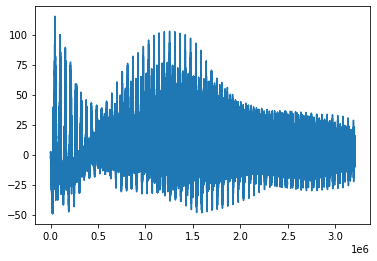

In [72]:
plt.plot( u1.flatten())

In [48]:
bmid=ds2['hybm'].values
amid=ds2['hyam'].values
bint=ds2['hybi'].values
aint=ds2['hyai'].values

pmid, pint, delp \
    = MkP.Pressure (am=amid ,
                    bm=bmid ,
                    ai=aint ,
                    bi=bint,
                    ps=ps2,
                    p_00=100_000.  ,
                    Gridkey = 'zyx' )



Issue is that 'zERA' in Python code is being defined using ps_CAM, while in W&O 'zERA' is being defined with 'ps_old' (aka ps_ERA_xCAM in Python code )

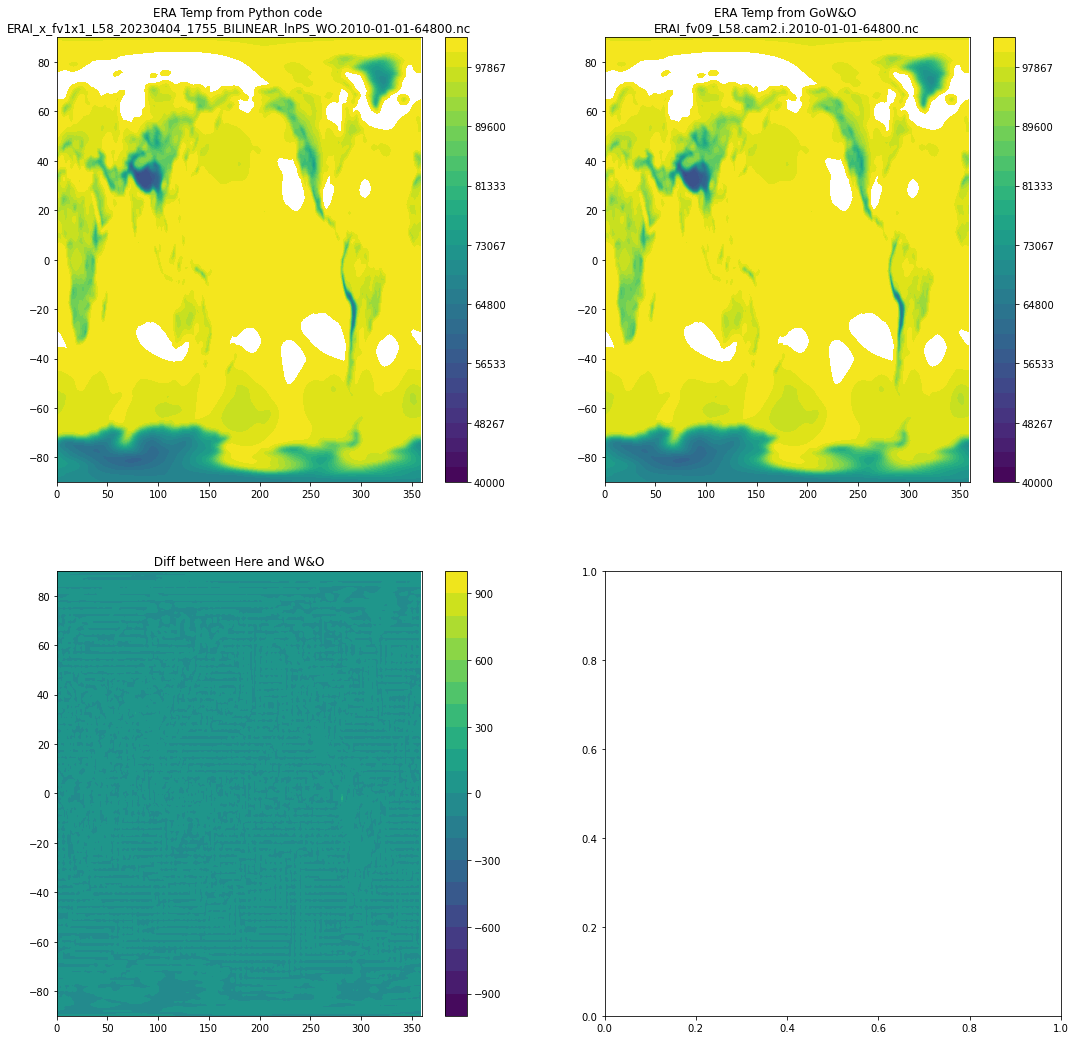

In [49]:
clev=np.linspace(40_000.,102_000.,num=31)
dlev=100.*np.linspace(-10,10,num=21)
#clev=np.linspace(277,287,num=31)
#ERA - 89 128
#CAM -124 72

# Global
elon,wlon=0,360
slat,nlat=-90,90

# Tibet ...
#elon,wlon=70,100
#slat,nlat=25,40

# Andes ...
#elon,wlon=280,300
#slat,nlat=-40,-10

# Himalayan Front
#elon,wlon=85,95
#slat,nlat=25,28


kCAM=30 #57

nCAM=3

fig,ax = plt.subplots(2,2,figsize=(18,18) ,squeeze=False )

i,j=0,0
cf = ax[i,j].contourf( lono, lato, ps2[:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from Python code \n"+file2)
plt.colorbar(cf,ax=ax[i,j] )

i,j=0,1
cf = ax[i,j].contourf( lono, lato, ps1[:,:],levels=clev )
#cf = ax[i,j].contourf( lono, lato, ps1[:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from GoW&O \n"+file1)
plt.colorbar(cf,ax=ax[i,j] )

i,j=1,0
cf = ax[i,j].contourf( lono, lato, diff_ps ,levels=dlev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
#ax[i,j].set_title("ERA Temp on CAM Z-grid and CAM H-grid, but from W&O regridder")
ax[i,j].set_title(" Diff between Here and W&O ")
plt.colorbar(cf,ax=ax[i,j] )


9098.699
6.4040016020509825
17.66048239671579


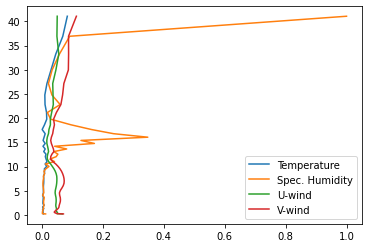

In [78]:
diff_ps = ps2 - ps1
diff_te = t2  - t1
diff_qv = q2  - q1
diff_uu = u2  - u1
diff_vv = v2  - v1

print( np.std( ps1 ,axis=(0,1) ))
print( np.sqrt(np.average( diff_ps**2 ,axis=(0,1) ) ))

norm_diff_te_z = np.sqrt( np.average(diff_te**2,axis=(1,2)) )  / ( np.std( t2 ,axis=(1,2) ) )
norm_diff_qv_z = np.sqrt( np.average(diff_qv**2,axis=(1,2)) )  / ( np.std( q2 ,axis=(1,2) ) )
norm_diff_uu_z = np.sqrt( np.average(diff_uu**2,axis=(1,2)) )  / ( np.std( u2 ,axis=(1,2) ) )

norm_diff_vv_z = np.sqrt( np.average(diff_vv**2,axis=(1,2)) )  / ( np.std( v2 ,axis=(1,2) ) )

plev = np.average( pmid, axis=(1,2) )
zlev = -7.0*np.log(plev/100_000.)

plt.plot(  norm_diff_te_z , zlev , label='Temperature' ) 
plt.plot(  norm_diff_qv_z , zlev , label='Spec. Humidity' ) 
plt.plot(  norm_diff_uu_z , zlev , label='U-wind' ) 
plt.plot(  norm_diff_vv_z , zlev , label='V-wind' ) 
plt.legend()
print(zlev[10])

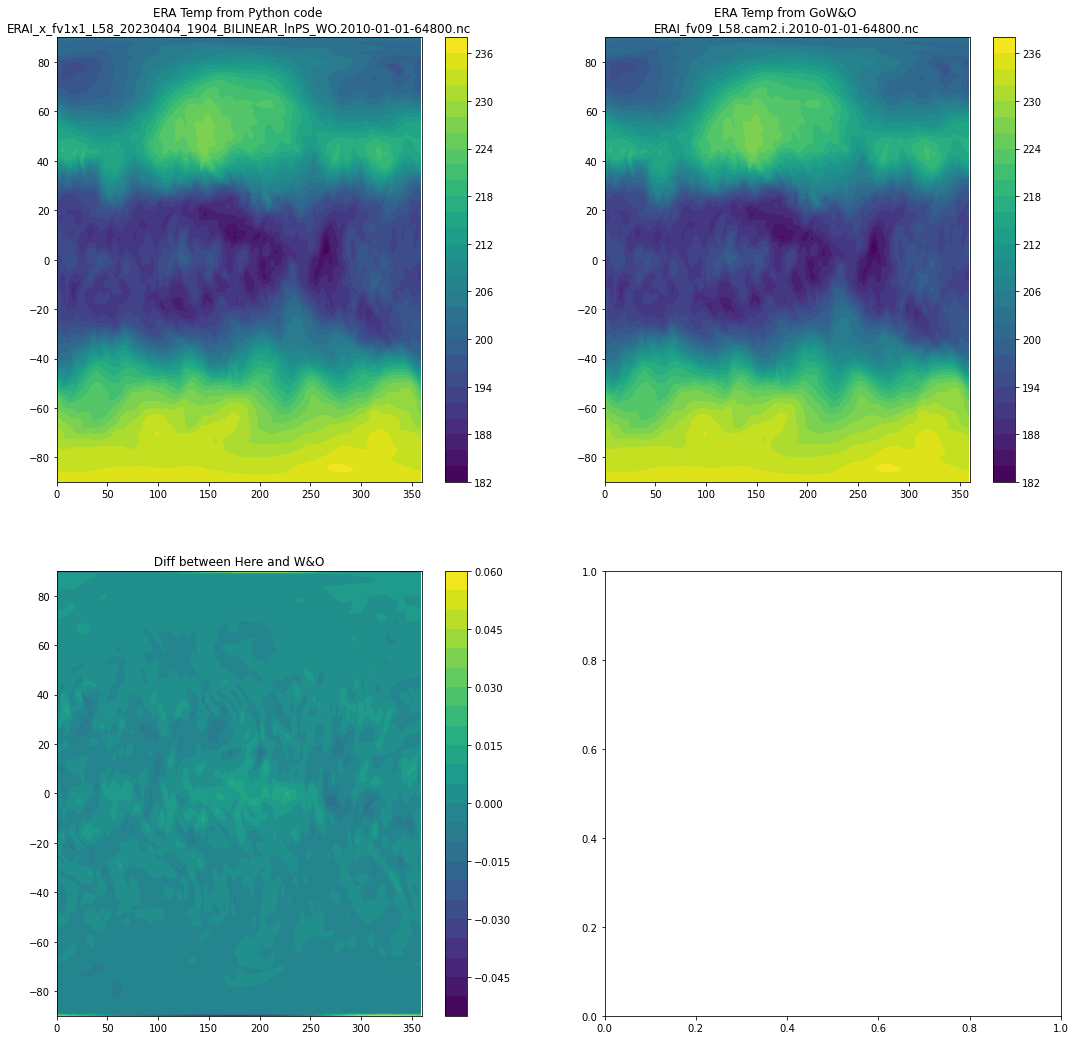

In [80]:
clev=31 #(1e-8)*np.linspace(0,1.,num=31)
dlev=21 #(1e-8)*np.linspace(-10,10,num=21)
#clev=np.linspace(277,287,num=31)
#ERA - 89 128
#CAM -124 72

# Global
elon,wlon=0,360
slat,nlat=-90,90

# Tibet ...
#elon,wlon=70,100
#slat,nlat=25,40

# Andes ...
#elon,wlon=280,300
#slat,nlat=-40,-10

# Himalayan Front
#elon,wlon=85,95
#slat,nlat=25,28


kCAM=10 #57

nCAM=3

fig,ax = plt.subplots(2,2,figsize=(18,18) ,squeeze=False )

i,j=0,0
cf = ax[i,j].contourf( lono, lato, t2[kCAM,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from Python code \n"+file2)
plt.colorbar(cf,ax=ax[i,j] )

i,j=0,1
cf = ax[i,j].contourf( lono, lato, t1[kCAM,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from GoW&O \n"+file1)
plt.colorbar(cf,ax=ax[i,j] )



i,j=1,0
cf = ax[i,j].contourf( lono, lato, diff_te[kCAM,:,:] ,levels=dlev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
#ax[i,j].set_title("ERA Temp on CAM Z-grid and CAM H-grid, but from W&O regridder")
ax[i,j].set_title(" Diff between Here and W&O ")
plt.colorbar(cf,ax=ax[i,j] )


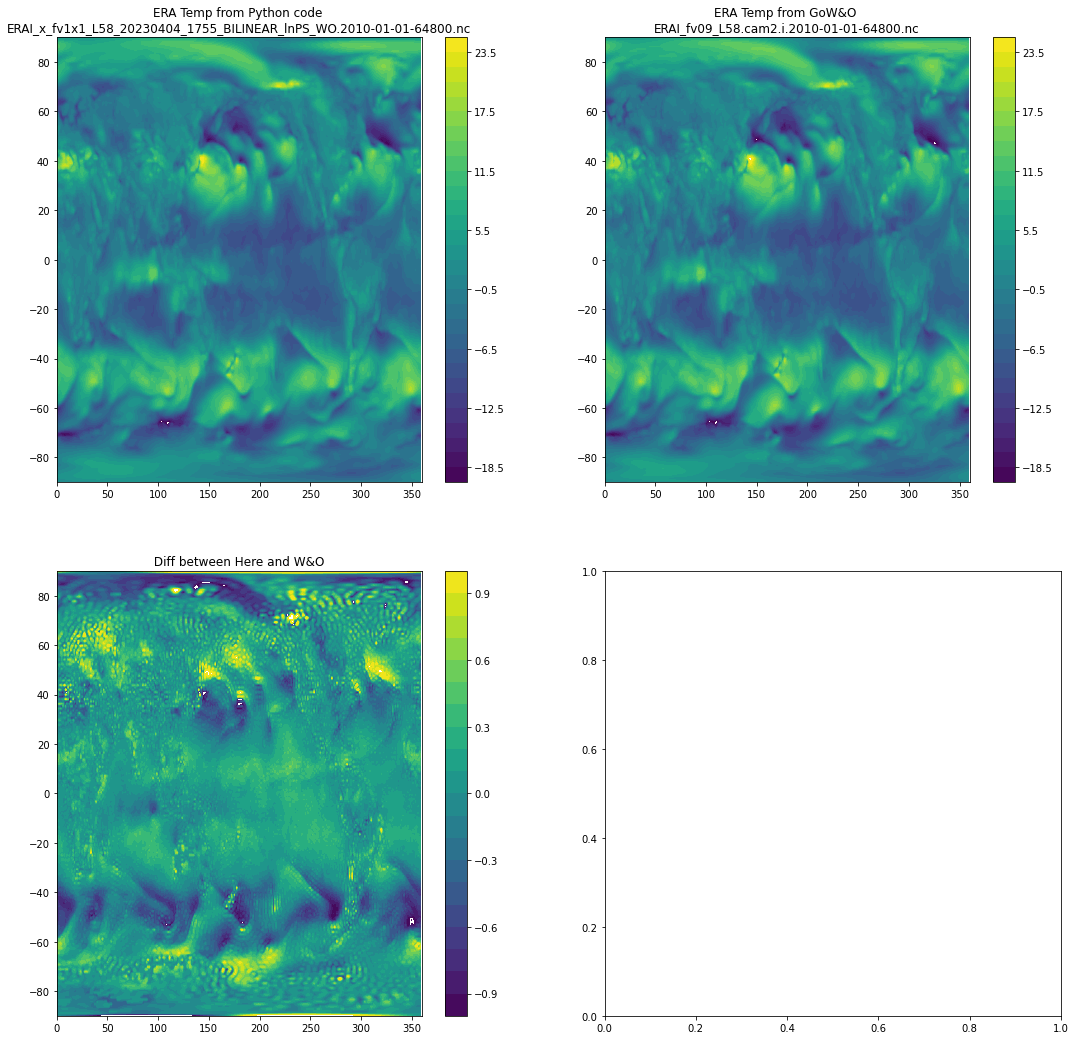

In [57]:
clev=.25*np.linspace(-80,100,num=31)
dlev=.1*np.linspace(-10,10,num=21)
#clev=np.linspace(277,287,num=31)
#ERA - 89 128
#CAM -124 72

# Global
elon,wlon=0,360
slat,nlat=-90,90

# Tibet ...
#elon,wlon=70,100
#slat,nlat=25,40

# Andes ...
#elon,wlon=280,300
#slat,nlat=-40,-10

# Himalayan Front
#elon,wlon=85,95
#slat,nlat=25,28


kCAM=57 #57

nCAM=3

fig,ax = plt.subplots(2,2,figsize=(18,18) ,squeeze=False )

i,j=0,0
cf = ax[i,j].contourf( lono, lato, u2[kCAM,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from Python code \n"+file2)
plt.colorbar(cf,ax=ax[i,j] )

i,j=0,1
cf = ax[i,j].contourf( lono, lato, u1[kCAM,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from GoW&O \n"+file1)
plt.colorbar(cf,ax=ax[i,j] )



i,j=1,0
cf = ax[i,j].contourf( lono, lato, diff_uu[kCAM,:,:] ,levels=dlev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
#ax[i,j].set_title("ERA Temp on CAM Z-grid and CAM H-grid, but from W&O regridder")
ax[i,j].set_title(" Diff between Here and W&O ")
plt.colorbar(cf,ax=ax[i,j] )


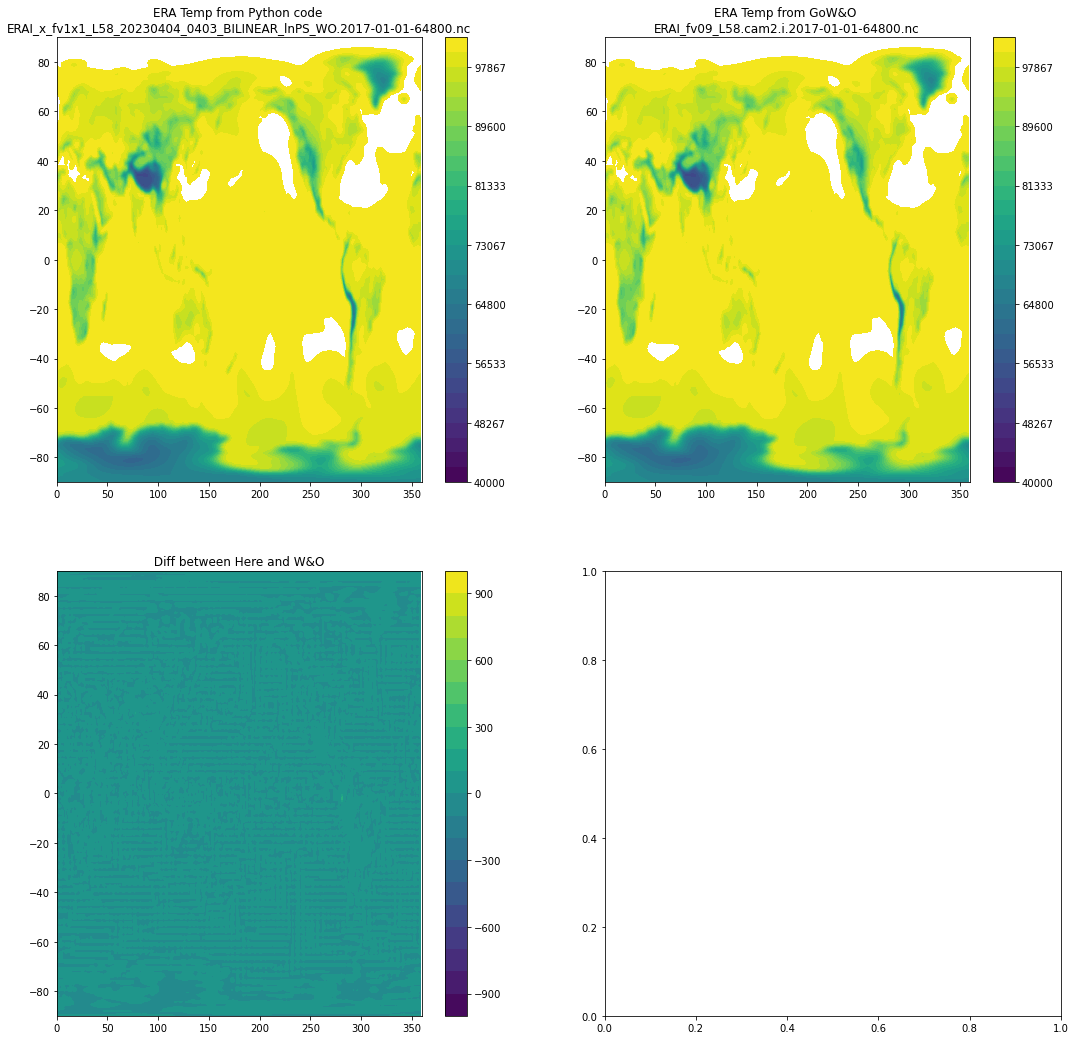

In [10]:
clev=np.linspace(40_000.,102_000.,num=31)
dlev=100.*np.linspace(-10,10,num=21)
#clev=np.linspace(277,287,num=31)
#ERA - 89 128
#CAM -124 72

# Global
elon,wlon=0,360
slat,nlat=-90,90

# Tibet ...
#elon,wlon=70,100
#slat,nlat=25,40

# Andes ...
#elon,wlon=280,300
#slat,nlat=-40,-10

# Himalayan Front
#elon,wlon=85,95
#slat,nlat=25,28


kCAM=30 #57

nCAM=3

fig,ax = plt.subplots(2,2,figsize=(18,18) ,squeeze=False )

i,j=0,0
cf = ax[i,j].contourf( lono, lato, ps2[:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from Python code \n"+file2)
plt.colorbar(cf,ax=ax[i,j] )

i,j=0,1
cf = ax[i,j].contourf( lono, lato, ps1[:,:],levels=clev )
#cf = ax[i,j].contourf( lono, lato, ps1[:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from GoW&O \n"+file1)
plt.colorbar(cf,ax=ax[i,j] )

i,j=1,0
cf = ax[i,j].contourf( lono, lato, diff_ps ,levels=dlev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
#ax[i,j].set_title("ERA Temp on CAM Z-grid and CAM H-grid, but from W&O regridder")
ax[i,j].set_title(" Diff between Here and W&O ")
plt.colorbar(cf,ax=ax[i,j] )


In [ ]:
clev=np.linspace(0.,50_000.,num=31)
dlev=10.*np.linspace(-10,10,num=21)
#clev=np.linspace(277,287,num=31)
#ERA - 89 128
#CAM -124 72

# Global
elon,wlon=0,360
slat,nlat=-90,90

# Tibet ...
#elon,wlon=70,100
#slat,nlat=25,40

# Andes ...
#elon,wlon=280,300
#slat,nlat=-40,-10

# Himalayan Front
#elon,wlon=85,95
#slat,nlat=25,28


kCAM=30 #57

nCAM=3

fig,ax = plt.subplots(2,2,figsize=(18,18) ,squeeze=False )

i,j=0,0
cf = ax[i,j].contourf( lono, lato, phis2[:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from Python code \n"+file2)
plt.colorbar(cf,ax=ax[i,j] )

i,j=0,1
cf = ax[i,j].contourf( lono, lato, phis1[0,:,:],levels=clev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
ax[i,j].set_title("ERA Temp from GoW&O \n"+file1)
plt.colorbar(cf,ax=ax[i,j] )


diff_te = phis2[:,:] - phis1[0,:,:]

i,j=1,0
cf = ax[i,j].contourf( lono, lato, diff_te ,levels=dlev )
ax[i,j].set_xlim(elon,wlon)
ax[i,j].set_ylim(slat,nlat)
#ax[i,j].set_title("ERA Temp on CAM Z-grid and CAM H-grid, but from W&O regridder")
ax[i,j].set_title(" Diff between Here and W&O ")
plt.colorbar(cf,ax=ax[i,j] )


In [ ]:
# Let's look at some interensitng points here
#
location="Himalayas"
location="Andes"

if (location=="Himalayas"):
    #Himalayan peaks
    ilon=np.argmin( np.abs( lon_CAM - 76. ))
    ilat=np.argmin( np.abs( lat_CAM - 36. ))
    ylim=(60_000.,42_000.)
    xlim=(240,270 )


if (location=="Andes"):
    #Andean peaks
    ilon=np.argmin( np.abs( lon_CAM - 290. ))
    ilat=np.argmin( np.abs( lat_CAM - (-30.) ))
    ylim=(75_000.,60_000.)
    xlim=(280,300 )

if (location=="Australia"):
    #Australia desert (Alice Springs)
    ilon=np.argmin( np.abs( lon_CAM - 135. ))
    ilat=np.argmin( np.abs( lat_CAM - (-23.4) ))
    ylim=(96_000.,85_000.)
    xlim=(280,320 )


#print(te_ERA_xzCAM[nCAM,kCAM,ilat,ilon] )



jCAM,iCAM=ilat,ilon

plt.plot( t2[:, jCAM, iCAM] , '-^' 
         , label='ERA Temp from Python code on xzCAM' )

plt.plot( t1 [0,:, jCAM, iCAM] , '-^' 
         , label='ERA Temp from W&O code' )


"""
plt.plot( te_ERA_xzCAM_wo2[:, jCAM, iCAM]+2 , press_CAM[:, jCAM, iCAM], '-*' 
         , label='ERA Temp on xzCAM from GUTS OF W&O' )
"""

#plt.ylim( ylim )
#plt.xlim( xlim )


plt.legend(loc='upper left')


In [ ]:
plt.plot( t1.flatten()-t2.flatten() )

In [ ]:
# Let's look at some interensitng points here
#
location="Himalayas"
#location="Andes"
nCAM=3

if (location=="Himalayas"):
    #Himalayan peaks
    ilon=np.argmin( np.abs( lon_CAM - 76. ))
    ilat=np.argmin( np.abs( lat_CAM - 36. ))
    ylim=(60_000.,42_000.)
    xlim=(-10,10 )


if (location=="Andes"):
    #Andean peaks
    ilon=np.argmin( np.abs( lon_CAM - 290. ))
    ilat=np.argmin( np.abs( lat_CAM - (-30.) ))
    ylim=(75_000.,50_000.)
    xlim=(-10,10 )

if (location=="Australia"):
    #Australia desert (Alice Springs)
    ilon=np.argmin( np.abs( lon_CAM - 135. ))
    ilat=np.argmin( np.abs( lat_CAM - (-23.4) ))
    ylim=(96_000.,85_000.)
    xlim=(-10,10 )


#print(te_ERA_xzCAM[nCAM,kCAM,ilat,ilon] )



jCAM,iCAM=ilat,ilon
"""
plt.plot( u_ERA_xCAM [nCAM,:, jCAM, iCAM] , pmid_CAM_zERA [nCAM,:, jCAM, iCAM], '-x' 
         , label='ERA U from Python code on xCAM and zERA' )


plt.plot( u_ERA_xzCAM [nCAM,:, jCAM, iCAM] , pmid_CAM [nCAM,:, jCAM, iCAM], '-^' 
         , label='ERA U from Python code on xzCAM' )
"""
plt.plot( q1 [0,:, jCAM, iCAM] , pmid_CAM [nCAM,:, jCAM, iCAM], '-^' 
         , label='ERA U from W&O code' )


"""
plt.plot( te_ERA_xzCAM_wo2[:, jCAM, iCAM]+2 , press_CAM[:, jCAM, iCAM], '-*' 
         , label='ERA Temp on xzCAM from GUTS OF W&O' )
"""

plt.ylim( ylim )
#plt.xlim( xlim )


plt.legend(loc='upper left')


In [ ]:
# Let's look at some interensitng points here
#
location="Himalayas"
#location="Andes"
nCAM=3

if (location=="Himalayas"):
    #Himalayan peaks
    ilon=np.argmin( np.abs( lon_CAM - 76. ))
    ilat=np.argmin( np.abs( lat_CAM - 36. ))
    ylim=(60_000.,42_000.)
    xlim=(-10,10 )


if (location=="Andes"):
    #Andean peaks
    ilon=np.argmin( np.abs( lon_CAM - 290. ))
    ilat=np.argmin( np.abs( lat_CAM - (-30.) ))
    ylim=(75_000.,50_000.)
    xlim=(-10,10 )

if (location=="Australia"):
    #Australia desert (Alice Springs)
    ilon=np.argmin( np.abs( lon_CAM - 135. ))
    ilat=np.argmin( np.abs( lat_CAM - (-23.4) ))
    ylim=(96_000.,85_000.)
    xlim=(-10,10 )


#print(te_ERA_xzCAM[nCAM,kCAM,ilat,ilon] )



jCAM,iCAM=ilat,ilon
plt.plot( u_ERA_xCAM [nCAM,:, jCAM, iCAM] , pmid_CAM_zERA [nCAM,:, jCAM, iCAM], '-x' 
         , label='ERA U from Python code on xCAM and zERA' )


plt.plot( u_ERA_xzCAM [nCAM,:, jCAM, iCAM] , pmid_CAM [nCAM,:, jCAM, iCAM], '-^' 
         , label='ERA U from Python code on xzCAM' )

plt.plot( u1 [0,:, jCAM, iCAM] , pmid_CAM [nCAM,:, jCAM, iCAM], '-^' 
         , label='ERA U from W&O code' )


"""
plt.plot( te_ERA_xzCAM_wo2[:, jCAM, iCAM]+2 , press_CAM[:, jCAM, iCAM], '-*' 
         , label='ERA Temp on xzCAM from GUTS OF W&O' )
"""

plt.ylim( ylim )
plt.xlim( xlim )


plt.legend(loc='upper left')


In [ ]:
Dphis = phis_ERA_xCAM - phis_CAM
plt.plot(Dphis.flatten()-dphis_WO.flatten() )

## Check Mapping files

In [ ]:


#ERA - 89 128
#CAM -124 72
jCAM,iCAM = 124,72
jERA,iERA = 89,128
nCAM = 3

plt.plot( te_ERA_xCAM [nCAM,:, jCAM, iCAM] , pmid_CAM_zERA [nCAM,:, jCAM, iCAM], '-x' 
         , label='ERA Temp from Python code on xCAM and zERA' )

plt.plot( te_ERA_xCAM_wo2[:, jCAM, iCAM] , press_ERA[:, jCAM, iCAM], '-o' 
         , label='ERA Temp on xCAM and zERA from GUTS OF W&O' )



#plt.plot( te_ERA_xzCAM [0,:,124, 72] , pmid_CAM [0,:,124, 72], '-o' , label='ERA Temp from Python code on xzCAM' )
#plt.plot( te_ERA[0,:,89, 128] ,pmid_ERA [0,:,89, 128] ,'-+', label='ERA Temp at closest xERA point' )


plt.ylim(88_000.,70_000.)
plt.xlim(270,290)
plt.legend()

print(ps_new[jCAM,iCAM])
print(ps_CAM[nCAM,jCAM,iCAM])

print(ps_old[jCAM,iCAM])
print(ps_ERA_xCAM[nCAM,jCAM,iCAM])



In [ ]:


#ERA - 89 128
#CAM -124 72
jCAM,iCAM = 124,72
jERA,iERA = 89,128
nCAM = 3

plt.plot( te_ERA_xCAM [nCAM,:, jCAM, iCAM] , pmid_CAM_zERA [nCAM,:, jCAM, iCAM], '-x' 
         , label='ERA Temp from Python code on xCAM and zERA' )

#plt.plot( te_ERA_xCAM_wo2[:, jCAM, iCAM] , press_ERA[:, jCAM, iCAM], '-o' 
#         , label='ERA Temp on xCAM and zERA from GUTS OF W&O' )


plt.plot( te_ERA_xzCAM [nCAM,:, jCAM, iCAM] , pmid_CAM [nCAM,:, jCAM, iCAM], '-^' 
         , label='ERA Temp from Python code on xzCAM' )

plt.plot( t1[0,:, jCAM, iCAM]+1 , pmid_CAM[nCAM,:, jCAM, iCAM], '-*' 
         , label='ERA Temp on xzCAM from W&O' )

plt.plot( t2[0,:, jCAM, iCAM]+.5 , pmid_CAM[nCAM,:, jCAM, iCAM], '-*' 
         , label='ERA Temp on xzCAM from W&O (simple TBOT)' )



#plt.plot( te_ERA_xzCAM [0,:,124, 72] , pmid_CAM [0,:,124, 72], '-o' , label='ERA Temp from Python code on xzCAM' )
#plt.plot( te_ERA[0,:,89, 128] ,pmid_ERA [0,:,89, 128] ,'-+', label='ERA Temp at closest xERA point' )


plt.ylim(88_000.,70_000.)
plt.xlim(270,290)
plt.legend()

#print(ps_new[jCAM,iCAM])
#print(ps_CAM[nCAM,jCAM,iCAM])

#print(ps_old[jCAM,iCAM])
#print(ps_ERA_xCAM[nCAM,jCAM,iCAM])

